# Engineering Predictive Alpha Factors

This notebook illustrates the following steps:

1. Select the adjusted open, high, low, and close prices as well as the volume for all tickers from the Quandl Wiki data that you downloaded and simplified for the last milestone for the 2007-2016 time period. Looking ahead, we will use 2014-2016 as our 'out-of-sample' period to test the performance of a strategy based on a machine learning model selected using data from preceding periods.
2. Compute the dollar volume as the product of closing price and trading volume; then select the stocks with at least eight years of data and the lowest average daily rank for this metric. 
3. Compute daily returns and keep only 'inliers' with values between -100% and + 100% as a basic check against data error.
4. Now we're ready to compute financial features. The Alpha Factory Library listed among the resources below illustrates how to compute a broad range of those using pandas and TA-Lib. We will list a few examples; feel free to explore and evaluate the various TA-Lib indicators.
    - Compute **historical returns** for various time ranges such as 1, 3, 5, 10, 21 trading days, as well as longer periods like 2, 3, 6 and 12 months.
    - Use TA-Lib's **Bollinger Band** indicator to create features that anticipate **mean-reversion**.
    - Select some indicators from TA-Lib's **momentum** indicators family such as
        - the Average Directional Movement Index (ADX), 
        - the Moving Average Convergence Divergence (MACD), 
        - the Relative Strength Index (RSI), 
        - the Balance of Power (BOP) indictor, or 
        - the Money Flow Index (MFI).
    - Compute TA-Lib **volume** indicators like On Balance Volume (OBV) or the Chaikin A/D Oscillator (ADOSC)
    - Create volatility metrics such as the Normalized Average True Range (NATR).
    - Compute rolling factor betas using the five Fama-French risk factors for different rolling windows of three and 12 months (see resources below).
    - Compute the outcome variable that we will aim to predict, namely the 1-day forward returns.

## Usage tips

- If you experience resource constraints (suddenly restarting Kernel), increase the memory available for Docker Desktop (> Settings > Advanced). If this not possible or you experienced prolonged execution times, reduce the scope of the exercise. The easiest way to do so is to select fewer stocks or a shorter time period, or both.
- You may want to persist intermediate results so you can recover quickly in case something goes wrong. There's an example under the first 'Persist Results' subsection.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from pandas.io.pytables import Term #added
from pandas import Timestamp #added
import datetime #added
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib
import math
import pylab
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Note to Mentors/Author: Why is this step required?

sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)
print(idx)
print(deciles)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


## Load Data

Load data from Quandl WIKI dataset, extract data from 2007-2016 with renamed columns open, high, low, close, volume, and partitioned out-of-sample from 2014 to 2016 as test data 

In [4]:
#Load data saved from simplified and transformed Quandl WIKI dataset
DATA_STORE = Path('/Users/lcheong/Documents/01_env_and_data/', 'us_stocks.h5')

In [5]:
with pd.HDFStore(DATA_STORE, mode = 'r') as store:
    df_retrieved = store.select('df')
    #Display information about the retrieved dataframe
    print(df_retrieved.info())
    print(df_retrieved.head())
    print(df_retrieved.describe())
  
    #Reduce multi-index to single level index based on date
    df_retrieved=df_retrieved.reset_index(0)
    
    #Extract data from 2007-2016 
    df_2007_2016 = df_retrieved.loc['2007':'2016']
   
    #Display information about the modified retrieved dataframe
    print(df_2007_2016.info())
    print(df_2007_2016.head())
    print(df_2007_2016.tail())
    print(df_2007_2016.describe())
    
    #Partition out-of-sample data from 2014 to 2016 as test data
    inSample = df_retrieved.loc['2007':'2014']
    OutofSample = df_retrieved.loc['2014':'2016']

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11343920 entries, ('A', Timestamp('2000-01-03 00:00:00')) to ('ZUMZ', Timestamp('2018-03-27 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 476.3+ MB
None
                        open       high        low      close     volume
ticker date                                                             
A      2000-01-03  53.726454  53.856080  45.969377  49.121329  3343600.0
       2000-01-04  46.481058  46.992738  44.175084  45.369006  3408500.0
       2000-01-05  45.198445  45.239380  41.828176  41.998737  4119200.0
       2000-01-06  42.046493  42.298923  39.658651  40.934441  1812900.0
       2000-01-07  40.293135  44.986951  40.252200  44.345645  2016900.0
               open          high           low         close        volume
count  1.134338e+07  1.134386e+0

## Select 500 most-traded stocks prior to 2017

Display number of stocks traded prior to 2017 and list 500 most-traded stocks prior to 2017.
Compute the dollar volume as the product of the adjusted close price and the adjusted volume.
Select the stocks with at least eight years of data and the lowest average daily rank for this metric.

In [6]:
#Number of stocks traded prior to 2017
print(df_2007_2016['ticker'].unique())
print("NO. OF TICKERS TRADED PRIOR TO 2017:",len(df_2007_2016['ticker'].unique())) #3186

#Reset index, to enable multi-index setting later
df_2007_2016=df_2007_2016.reset_index()


#500 most-traded stocks prior to 2017
mostTradedstocks = df_2007_2016.sort_values(by='volume', ascending=False)
print("First five most traded stocks : \n",mostTradedstocks.head())
mts = mostTradedstocks['ticker'].unique().tolist()
print("No. of unique tickers",len(mts)) #3186
five_hundred_mts = mts[0:500]
print("List of 500 most traded stocks :\n", five_hundred_mts,len(five_hundred_mts))


#Append dollar volume column as product of adjusted close price and adjusted volume
mostTradedstocks['dollar_volume'] = mostTradedstocks.close * mostTradedstocks.volume
                      
#Check for NaN and zero values, to avoid bias in volume column
print(mostTradedstocks.shape) #(6951845, 8)
print("Filter out rows for mostTradedstocks['volume']=0 and mostTradedstocks.isnull() values")  
mostTradedstocks = mostTradedstocks[mostTradedstocks['volume']!=0]
mostTradedstocks.dropna(inplace= False)
print(mostTradedstocks.shape)#(6913251, 8)


#Set index with date and ticker
print("INDEX IS SET WITH DATE AND TICKER")
mostTradedstocks=mostTradedstocks.set_index(['ticker','date'])
print(mostTradedstocks.head())


#Append duration column as a time delta between the start and end date of tradings
output1 = mostTradedstocks.reset_index(level=1).groupby(level=0, as_index=False)['date'].max()
output2 = mostTradedstocks.reset_index(level=1).groupby(level=0, as_index=False)['date'].min()
output3 = (output1-output2)/np.timedelta64(1,'Y') #convert day range to years
mostTradedstocks['duration']=''
for i in range(len(output3)):
    mostTradedstocks['duration'][i]=output3.iloc[i]['date']
    
mostTradedstocks['duration'] = pd.to_numeric(mostTradedstocks['duration'])
mostTradedstocks.info()

#2.0 instead of zero,which is desired. Min value should not be zero since we do not want to consider sparse data on dates where trading volume is zero
print("min", mostTradedstocks['dollar_volume'].min()) 


#Select the stocks with at least eight years of data 
mostTradedstocks = mostTradedstocks[(mostTradedstocks['duration'] >= 8)]
print("filtered_duration", mostTradedstocks) #2448 rows x 9 columns

#Rank based on dollar volume values using average method and select bottom 500.
mostTradedstocks['rank'] = mostTradedstocks['dollar_volume'].rank()

#Sort dollar volume values and review ranking
mostTradedstocks = mostTradedstocks.sort_values(by='rank', ascending=False)
print("Head",mostTradedstocks.head())
print("Tail",mostTradedstocks.tail())

#Reset index to enable ticker columns' selection
mostTradedstocks=mostTradedstocks.reset_index()

#Print out Results
select = mostTradedstocks['ticker'].unique().tolist()
print("Stocks with at least 8 years of data and 500 lowest average daily rank :\n",select[-500:])


['A' 'AA' 'AAL' ... 'ZQK' 'ZTS' 'ZUMZ']
NO. OF TICKERS TRADED PRIOR TO 2017: 3186
First five most traded stocks : 
              date ticker       open       high        low      close  \
936249 2010-02-11  BRK_B  74.500000  76.800000  74.150000  76.690000   
936248 2010-02-10  BRK_B  74.540000  74.585000  74.250000  74.420000   
936247 2010-02-09  BRK_B  74.720000  74.720000  73.900000  74.530000   
936241 2010-02-01  BRK_B  77.790000  78.000000  74.620000  75.410000   
653455 2009-12-04    BAC  14.823706  15.425684  14.692023  15.312813   

              volume  
936249  2.304019e+09  
936248  1.379239e+09  
936247  1.356373e+09  
936241  1.313149e+09  
653455  1.226791e+09  
No. of unique tickers 3186
List of 500 most traded stocks :
 ['BRK_B', 'BAC', 'AAPL', 'AIG', 'GE', 'V', 'VZ', 'SIRI', 'S', 'FB', 'RF', 'CSCO', 'F', 'C', 'WFC', 'GM', 'LVLT', 'YHOO', 'MS', 'MSFT', 'NFLX', 'INTC', 'GTAT', 'SLM', 'DELL', 'PFE', 'TYC', 'JCI', 'MA', 'MRO', 'CMCSA', 'JCP', 'KMI', 'BSX', 'PLUG', 'RAD',

## Compute returns

In [7]:
# (Adj Closing Price - Adj Opening Price)*No. of Stocks Owned
#Append returns column as difference between adjusted close price and adjusted opening price, multiplied by number of stocks owned (assume as 1)
mostTradedstocks['returns'] = mostTradedstocks.close - mostTradedstocks.open
print(mostTradedstocks.head())

  ticker       date   open   high    low  close        volume  dollar_volume  \
0  BRK_B 2010-02-11  74.50  76.80  74.15  76.69  2.304019e+09   1.766952e+11   
1  BRK_B 2010-02-09  74.72  74.72  73.90  74.53  1.356373e+09   1.010905e+11   
2  BRK_B 2010-02-05  72.25  73.69  71.61  73.57  1.173791e+09   8.635580e+10   
3  BRK_B 2010-02-04  73.80  73.80  72.05  72.61  1.119024e+09   8.125235e+10   
4  BRK_B 2010-02-02  75.70  76.17  74.91  75.51  7.978485e+08   6.024554e+10   

   duration    rank  returns  
0  9.990623  2447.0     2.19  
1  9.990623  2446.0    -0.19  
2  9.990623  2445.0     1.32  
3  9.990623  2444.0    -1.19  
4  9.990623  2443.0    -0.19  


## Remove outliers based on daily returns

In [8]:
#remove outliers from [-100%, +100%] range
mostTradedstocks = mostTradedstocks.drop(mostTradedstocks.index[(mostTradedstocks['returns']> +1.00000)])
mostTradedstocks = mostTradedstocks.drop(mostTradedstocks.index[(mostTradedstocks['returns']<-1.00000)])
print("UpdatedHead", mostTradedstocks.head())
print("UpdatedTail",mostTradedstocks.tail())


UpdatedHead    ticker       date       open       high        low      close  \
1   BRK_B 2010-02-09  74.720000  74.720000  73.900000  74.530000   
4   BRK_B 2010-02-02  75.700000  76.170000  74.910000  75.510000   
7   BRK_B 2010-02-12  77.150000  77.860000  74.570000  76.900000   
9    AAPL 2012-11-16  68.105580  68.728023  65.583405  68.426916   
11      C 2011-05-09  43.542826  43.765924  42.534037  42.834734   

          volume  dollar_volume  duration    rank   returns  
1   1.356373e+09   1.010905e+11  9.990623  2446.0 -0.190000  
4   7.978485e+08   6.024554e+10  9.990623  2443.0 -0.190000  
7   3.161342e+08   2.431072e+10  9.990623  2440.0 -0.250000  
9   3.167234e+08   2.167241e+10  9.270553  2438.0  0.321336  
11  4.916810e+08   2.106102e+10  9.990623  2436.0 -0.708092  
UpdatedTail      ticker       date      open      high       low     close       volume  \
2442   SUNE 2016-04-04  0.271000  0.295000  0.195000  0.211000  150146764.0   
2443   SIRI 2009-02-05  0.175499  0.1

In [31]:
#View interesting tickers 
interesting_tickers=['PLUG', 'AMD', 'MU', 'FSLR']
index = pd.DataFrame()
for i in interesting_tickers:
    if index.empty:
        index = mostTradedstocks[mostTradedstocks['ticker']==i]
    else:
      
        index = index.append(mostTradedstocks[mostTradedstocks['ticker']== i ],ignore_index=True)
 
        
        
index
#data = mostTradedstocks['ticker'].loc['MU']
#print(data.head())

,ticker,date,open,high,low,close,volume,dollar_volume,duration,rank,returns
0,PLUG,2014-03-13,7.58,8.48,6.96,8.00,131348100.0,1.050785e+09,9.990623,255.0,0.42
1,PLUG,2014-03-12,5.82,7.40,5.32,6.80,140949000.0,9.584532e+08,9.990623,227.0,0.98
2,AMD,2009-11-12,6.64,6.73,6.35,6.48,163101700.0,1.056899e+09,9.990623,260.0,-0.16
3,AMD,2016-09-09,6.23,6.24,5.85,5.90,170828036.0,1.007885e+09,9.990623,239.0,-0.33
4,AMD,2014-07-15,4.63,4.80,4.41,4.53,156113700.0,7.071951e+08,9.990623,170.0,-0.10
5,AMD,2013-07-19,3.99,4.08,3.85,4.03,151516000.0,6.106095e+08,9.990623,161.0,0.04
6,AMD,2016-04-22,3.19,3.99,3.18,3.99,143265305.0,5.716286e+08,9.990623,151.0,0.80
7,MU,2015-06-26,20.27,20.60,19.43,19.66,149010345.0,2.929543e+09,9.990623,1294.0,-0.61
8,MU,2010-04-01,11.03,11.05,10.11,10.17,127588500.0,1.297575e+09,9.990623,333.0,-0.86


## Bollinger Band

Bollinger Band measures specific number of standard deviations above and below the moving average, to determine if the trend is upward (bull) or downward (bear). This is an overlay indicator that is used with the charts of tickers monitored to find out its trend.  
+1SD or +2SD denotes an upward trend - BUY zone, long  
-1SD or -2SD denotes a downward trend - SELL zone, short  
between [-1SD, +1SD] denotes a neutral trend - NO ACTION

[Text(0, 0.5, 'Price')]

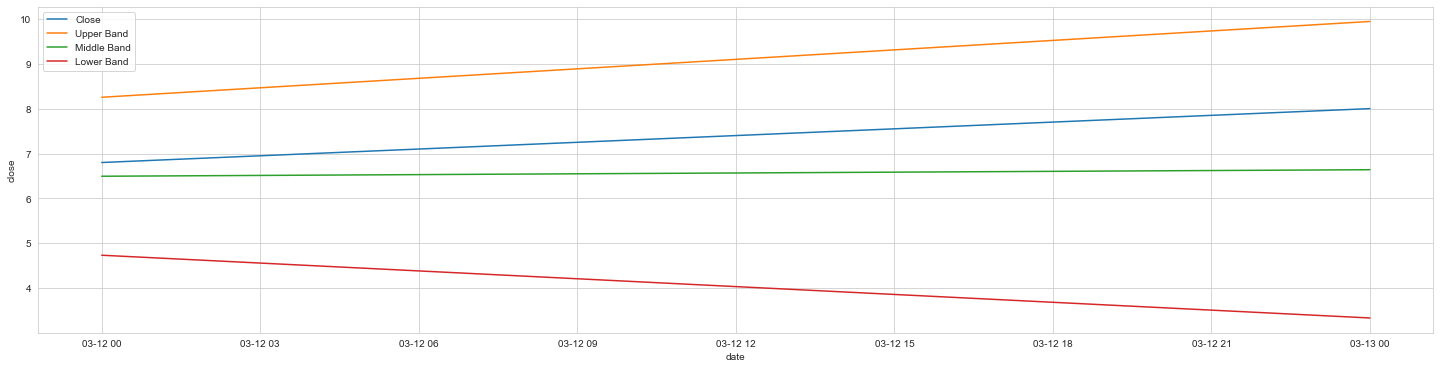

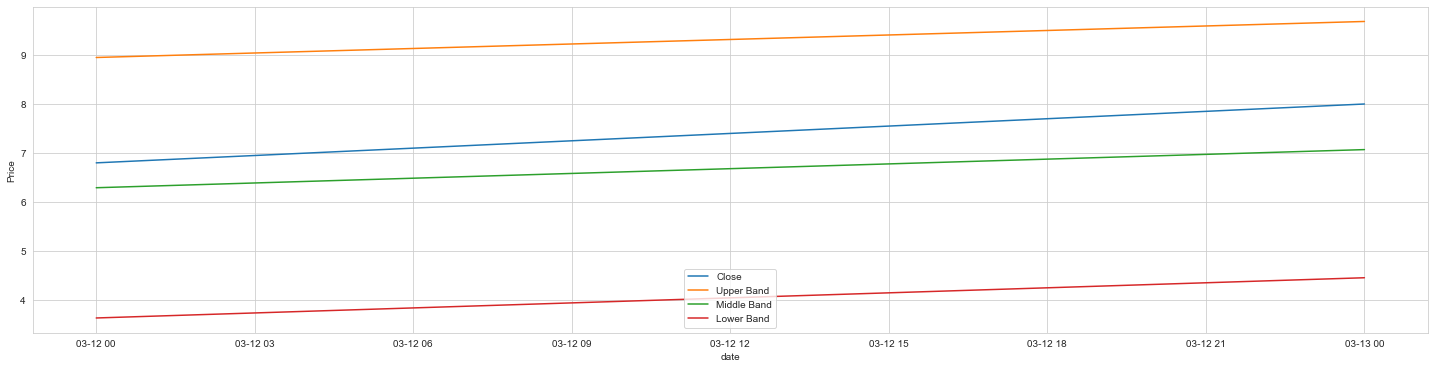

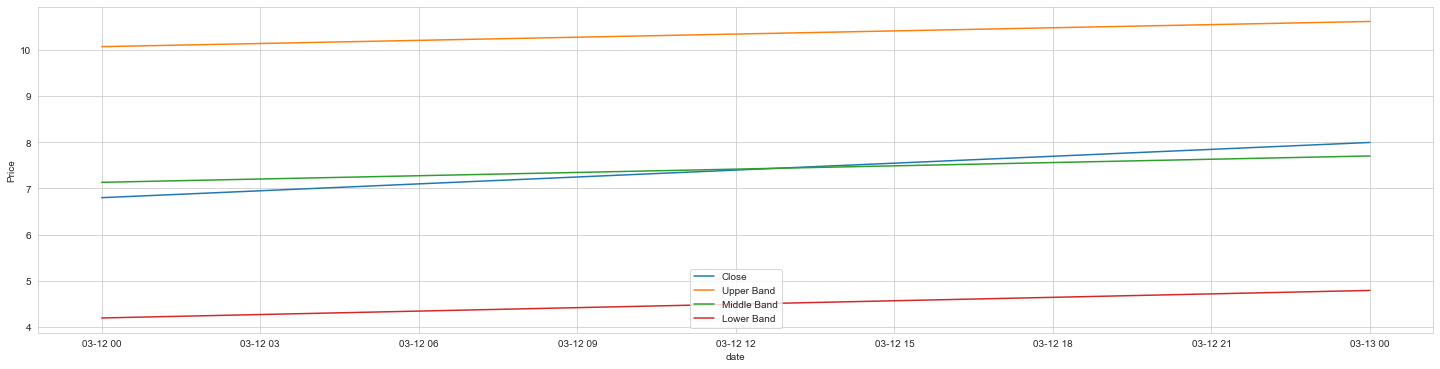

In [33]:
from talib import MA_Type

upper,middle,lower = talib.BBANDS(mostTradedstocks['close'], matype=MA_Type.T3)
mostTradedstocks['upperband'] = upper
mostTradedstocks['middleband'] = middle # Moving average
mostTradedstocks['lowerband'] = lower
plt.figure(figsize=(25,6))
sns.lineplot(x = 'date', y = 'close', data=mostTradedstocks[mostTradedstocks['ticker']=='PLUG'], label='Close')
sns.lineplot(x = 'date', y = 'upperband', data=mostTradedstocks[mostTradedstocks['ticker']=='PLUG'], label='Upper Band')
sns.lineplot(x = 'date', y = 'middleband', data=mostTradedstocks[mostTradedstocks['ticker']=='PLUG'], label='Middle Band')
ax = sns.lineplot(x = 'date', y = 'lowerband', data=mostTradedstocks[mostTradedstocks['ticker']=='PLUG'], label='Lower Band')

upper, middle, lower = talib.BBANDS(mostTradedstocks['close'], timeperiod=30)
mostTradedstocks['upperband'] = upper
mostTradedstocks['middleband'] = middle # Moving average
mostTradedstocks['lowerband'] = lower
plt.figure(figsize=(25,6))
sns.lineplot(x = 'date', y = 'close', data=mostTradedstocks[mostTradedstocks['ticker']=='PLUG'], label='Close')
sns.lineplot(x = 'date', y = 'upperband', data=mostTradedstocks[mostTradedstocks['ticker']=='PLUG'], label='Upper Band')
sns.lineplot(x = 'date', y = 'middleband', data=mostTradedstocks[mostTradedstocks['ticker']=='PLUG'], label='Middle Band')
ax = sns.lineplot(x = 'date', y = 'lowerband', data=mostTradedstocks[mostTradedstocks['ticker']=='PLUG'], label='Lower Band')
ax.set(ylabel='Price')

upper, middle, lower = talib.BBANDS(mostTradedstocks['close'], timeperiod=90)
mostTradedstocks['upperband'] = upper
mostTradedstocks['middleband'] = middle # Moving average
mostTradedstocks['lowerband'] = lower
plt.figure(figsize=(25,6))
sns.lineplot(x = 'date', y = 'close', data=mostTradedstocks[mostTradedstocks['ticker']=='PLUG'], label='Close')
sns.lineplot(x = 'date', y = 'upperband', data=mostTradedstocks[mostTradedstocks['ticker']=='PLUG'], label='Upper Band')
sns.lineplot(x = 'date', y = 'middleband', data=mostTradedstocks[mostTradedstocks['ticker']=='PLUG'], label='Middle Band')
ax = sns.lineplot(x = 'date', y = 'lowerband', data=mostTradedstocks[mostTradedstocks['ticker']=='PLUG'], label='Lower Band')
ax.set(ylabel='Price')

## TA-Lib's Momentum Indicators

Momentum Indicators measure the rate of rise or fall of stock prices.  

Here I choose to try out Moving Average Convergence/Divergence and Stochastic Relative Strength Index in TA-Lib functions

|Function|             Name|
|:---|:---|
|PLUS_DM|              Plus Directional Movement|
|MINUS_DM|             Minus Directional Movement|
|PLUS_DI|              Plus Directional Indicator|
|MINUS_DI|             Minus Directional Indicator|
|DX|                   Directional Movement Index|
|ADX|                  Average Directional Movement Index|
|ADXR|                 Average Directional Movement Index Rating|
|APO|                  Absolute Price Oscillator|
|PPO|                  Percentage Price Oscillator|
|AROON|                Aroon|
|AROONOSC|             Aroon Oscillator|
|BOP|                  Balance Of Power|
|CCI|                  Commodity Channel Index|
|CMO|                  Chande Momentum Oscillator|
|MACD|                 Moving Average Convergence/Divergence|
|MACDEXT|              MACD with controllable MA type|
|MACDFIX|              Moving Average Convergence/Divergence Fix 12/26|
|MFI|                  Money Flow Index|
|MOM|                  Momentum|
|RSI|                  Relative Strength Index|
|STOCH|                Stochastic|
|STOCHF|               Stochastic Fast|
|STOCHRSI|             Stochastic Relative Strength Index|
|TRIX|                 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA|
|ULTOSC|               Ultimate Oscillator|
|WILLR|                Williams' %R|

### Average Directional Movement Index (ADX)

The ADX combines of two other indicators, namely the positive and directional indicators (PLUS_DI and MINUS_DI), which in turn build on the positive and directional movement (PLUS_DM and MINUS_DM). For additional details see [Wikipdia](https://en.wikipedia.org/wiki/Average_directional_movement_index) and [Investopedia](https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp).

### Absolute Price Oscillator (APO)

The absolute Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as an absolute value. The EMA windows usually contain 26 and 12 data points, respectively.

### Percentage Price Oscillator (PPO)

The Percentage Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as a percentage value and thus comparable across assets. The EMA windows usually contain 26 and 12 data points, respectively. 

### Aroon Oscillator

#### Aroon Up/Down Indicator

The indicator measures the time between highs and the time between lows over a time period. It computes an AROON_UP and an AROON_DWN indicator as follows:

$$
\begin{align*}
\text{AROON_UP}&=\frac{T-\text{Periods since T period High}}{T}\times 100\\
\text{AROON_DWN}&=\frac{T-\text{Periods since T period Low}}{T}\times 100
\end{align*}
$$

#### Aroon Oscillator

The Aroon Oscillator is simply the difference between the Aroon Up and Aroon Down indicators.

### Balance Of Power (BOP)

The Balance of Power (BOP) intends to measure the strength of buyers relative to sellers in the market by assessing the ability of each side to drive prices. It is computer as the difference between the close and the open price, divided by the difference between the high and the low price: 

$$
\text{BOP}_t= \frac{P_t^\text{Close}-P_t^\text{Open}}{P_t^\text{High}-P_t^\text{Low}}
$$

### Commodity Channel Index (CCI)

The Commodity Channel Index (CCI) measures the difference between the current *typical* price, computed as the average of current low, high and close price and the historical average price. A positive (negative) CCI indicates that price is above (below) the historic average. When CCI is below zero, the price is below the hsitoric average. It is computed as:

$$
\begin{align*}
\bar{P_t}&=\frac{P_t^H+P_t^L+P_t^C}{3}\\
\text{CCI}_t & =\frac{\bar{P_t} - \text{SMA}(T)_t}{0.15\sum_{t=i}^T |\bar{P_t}-\text{SMA}(N)_t|/T}
\end{align*}
$$

### Moving Average Convergence/Divergence (MACD)

Moving Average Convergence Divergence (MACD) is a trend-following (lagging) momentum indicator that shows the relationship between two moving averages of a security’s price. It is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

The TA-Lib implementation returns the MACD value and its signal line, which is the 9-day EMA of the MACD. In addition, the MACD-Histogram measures the distance between the indicator and its signal line.

[Text(0, 0.5, 'Price')]

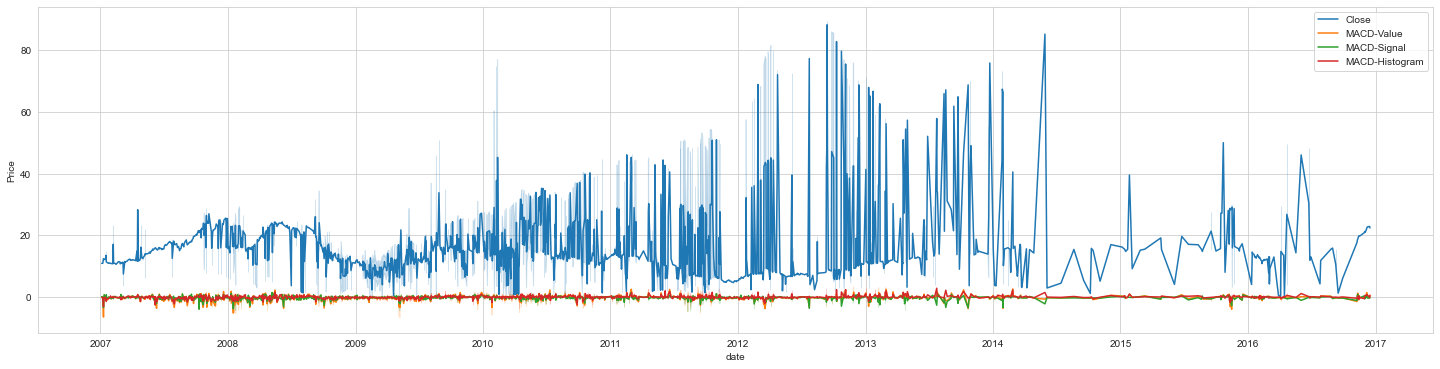

In [34]:
macd, macdsignal, macdhist = talib.MACDFIX(mostTradedstocks['close'], signalperiod=9)
mostTradedstocks['macd'] = macd
mostTradedstocks['macdsignal'] = macdsignal #9-day EMA
mostTradedstocks['macdhist'] = macdhist
plt.figure(figsize=(25,6))
sns.lineplot(x = 'date', y = 'close', data=mostTradedstocks, label='Close')
sns.lineplot(x = 'date', y = 'macd', data=mostTradedstocks, label='MACD-Value')
sns.lineplot(x = 'date', y = 'macdsignal', data=mostTradedstocks, label='MACD-Signal')
ax = sns.lineplot(x = 'date', y = 'macdhist', data=mostTradedstocks, label='MACD-Histogram')
ax.set(ylabel='Price')

### Chande Momentum Oscillator (CMO)

The Chande Momentum Oscillator (CMO) intends to measure momentum on both up and down days. It is calculated as the difference between the sum of gains and losses over at time period T, divided by the sum of all price movement over the same period. It oscillates between +100 and -100.

### Money Flow Index

The Money Flow Index (MFI) incorporates price and volume information to identify overbought or oversold conditions.  The indicator is typically calculated using 14 periods of data. An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold.

### Relative Strength Index

RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold. A high RSI (usually above 70) indicates overbought and a low RSI (typically below 30) indicates oversold. It first computes the average price change for a given number (often 14) of prior trading days with rising and falling prices, respectively as $\text{up}_t$ and $\text{down}_t$. Then, the RSI is computed as:
$$
\text{RSI}_t=100-\frac{100}{1+\frac{\text{up}_t}{\text{down}_t}}
$$



#### Stochastic RSI (STOCHRSI)

The Stochastic Relative Strength Index (STOCHRSI) is based on the RSI just described and intends to identify crossovers as well as overbought and oversold conditions. It compares the distance of the current RSI to the lowest RSI over a given time period T to the maximum range of values the RSI has assumed for this period. It is computed as follows:

$$
\text{STOCHRSI}_t= \frac{\text{RSI}_t-\text{RSI}_t^L(T)}{\text{RSI}_t^H(T)-\text{RSI}_t^L(T)}
$$

The TA-Lib implementation offers more flexibility than the original "Unsmoothed stochastic RSI" version by Chande and Kroll (1993). To calculate the original indicator, keep the `timeperiod` and `fastk_period` equal. 

The return value `fastk` is the unsmoothed RSI. The `fastd_period` is used to compute a smoothed STOCHRSI, which  is returned as `fastd`. If you do not care about STOCHRSI smoothing, just set `fastd_period` to 1 and ignore the `fastd` output.

Reference: "Stochastic RSI and Dynamic Momentum Index" by Tushar Chande and Stanley Kroll Stock&Commodities V.11:5 (189-199)


In [ ]:
fastk, fastd = talib.STOCHRSI(mostTradedstocks['close'], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)


### Stochastic (STOCH)

A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. Stochastic oscillators are based on the idea that closing prices should confirm the trend.

For stochastic (STOCH), there are four different lines: `FASTK`, `FASTD`, `SLOWK` and `SLOWD`. The `D` is the signal line usually drawn over its corresponding `K` function.

$$
\begin{align*}
& K^\text{Fast}(T_K) & = &\frac{P_t-P_{T_K}^L}{P_{T_K}^H-P_{T_K}^L}* 100 \\
& D^\text{Fast}(T_{\text{FastD}}) & = & \text{MA}(T_{\text{FastD}})[K^\text{Fast}]\\
& K^\text{Slow}(T_{\text{SlowK}}) & = &\text{MA}(T_{\text{SlowK}})[K^\text{Fast}]\\
& D^\text{Slow}(T_{\text{SlowD}}) & = &\text{MA}(T_{\text{SlowD}})[K^\text{Slow}]
\end{align*}
$$
  

The $P_{T_K}^L$, $P_{T_K}^H$, and $P_{T_K}^L$ are the extreme values among the last $T_K$ period.
 $K^\text{Slow}$ and $D^\text{Fast}$ are equivalent when using the same period. 

### Ultimate Oscillator (ULTOSC)

The Ultimate Oscillator (ULTOSC), developed by Larry Williams, measures the average difference of the current close to the previous lowest price over three time frames (default: 7, 14, and 28) to avoid overreacting to short-term price changes and incorporat short, medium, and long-term market trends. It first computes the buying pressure, $\text{BP}_t$, then sums it over the three periods $T_1, T_2, T_3$, normalized by the True Range ($\text{TR}_t$.
$$
\begin{align*}
\text{BP}_t & = P_t^\text{Close}-\min(P_{t-1}^\text{Close}, P_t^\text{Low})\\ 
\text{TR}_t & = \max(P_{t-1}^\text{Close}, P_t^\text{High})-\min(P_{t-1}^\text{Close}, P_t^\text{Low})
\end{align*}
$$

ULTOSC is then computed as a weighted average over the three periods as follows:
$$
\begin{align*}
\text{Avg}_t(T) & = \frac{\sum_{i=0}^{T-1} \text{BP}_{t-i}}{\sum_{i=0}^{T-1} \text{TR}_{t-i}}\\
\text{ULTOSC}_t & = 100*\frac{4\text{Avg}_t(7) + 2\text{Avg}_t(14) + \text{Avg}_t(28)}{4+2+1}
\end{align*}
$$

### Williams' %R (WILLR)

Williams %R, also known as the Williams Percent Range, is a momentum indicator that moves between 0 and -100 and measures overbought and oversold levels to identify entry and exit points. It is similar to the Stochastic oscillator and compares the current closing price $P_t^\text{Close}$ to the range of highest ($P_T^\text{High}$) and lowest ($P_T^\text{Low}$) prices over the last T periods (typically 14). The indicators is computed as:

$$
\text{WILLR}_t = \frac{P_T^\text{High}-P_t^\text{Close}}{P_T^\text{High}-P_T^\text{Low}}
$$


## Volume Indicators

In [ ]:
Indicators that are used to analyse the trading volume are: 

|Function|             Name|
|:---|:---|
|AD|                   Chaikin A/D Line|
|ADOSC|                Chaikin A/D Oscillator|
|OBV|                  On Balance Volume|

### Chaikin A/D Line

The Chaikin Advance/Decline or Accumulation/Distribution Line (AD) is a volume-based indicator designed to measure the cumulative flow of money into and out of an asset. The indicator assumes that the degree of buying or selling pressure can be determined by the location of the close, relative to the high and low for the period. There is buying (sellng) pressure when a stock closes in the upper (lower) half of a period's range. The intention is to signal a change in direction when the indicator diverges from the security price.

The Accumulation/Distribution Line is a running total of each period's Money Flow Volume. It is calculated as follows:

1. The Money Flow Multiplier (MFI) is the relationship of the close to the high-low range:
2. The MFI is multiplied by the period's volume $V_t$ to come up with a Money Flow Volume (MFV). 
3. A running total of the Money Flow Volume forms the Accumulation Distribution Line:
$$
\begin{align*}
&\text{MFI}_t&=\frac{P_t^\text{Close}-P_t^\text{Low}}{P_t^\text{High}-P_t^\text{Low}}\\
&\text{MFV}_t&=\text{MFI}_t \times V_t\\
&\text{AD}_t&=\text{AD}_{t-1}+\text{MFV}_t
\end{align*}
$$

### Chaikin A/D Oscillator (ADOSC)

The Chaikin A/D Oscillator (ADOSC) is the Moving Average Convergence Divergence indicator (MACD) applied to the Chaikin A/D Line. The Chaikin Oscillator intends to predict changes in the Accumulation/Distribution Line.

It is computed as the difference between the 3-day exponential moving average and the 10-day exponential moving average of the Accumulation/Distribution Line.

### On Balance Volume (OBV)

The On Balance Volume indicator (OBV) is a cumulative momentum indicator that relates volume to price change. It assumes that OBV changes precede price changes because smart money can be seen flowing into the security by a rising OBV. When the public then moves into the security, both the security and OBV will rise. In short, rising OBV indicates positive volume pressure which can result in increasing prices while falling OBV indicates negative volume pressure which can result in decreasing prices.

The current OBV is computed by adding (subtracting) the current volume to the last OBV if the security closes higher (lower) than the previous close.

$$
\text{OBV}_t = 
\begin{cases}
\text{OBV}_{t-1}+V_t & \text{if }P_t>P_{t-1}\\
\text{OBV}_{t-1}-V_t & \text{if }P_t<P_{t-1}\\
\text{OBV}_{t-1} & \text{otherwise}
\end{cases}
$$

In [35]:
real = talib.OBV(mostTradedstocks['close'], mostTradedstocks['volume'])

## Volatility Indicators

|Function|             Name|
|:---|:---|
|TRANGE|               True Range|
|ATR|                  Average True Range|
|NATR|                 Normalized Average True Range|

### ATR

The Average True Range indicator (ATR) shows volatility of the market. It was introduced by Welles Wilder (1978)  and has been used as a component of numerous other indicators since. It aims to anticipate changes in trend such that the higher its value, the higher the probability of a trend change; the lower the indicator’s value, the weaker the current trend.

It is computed as the simple moving average for a period T of the True Range (TRANGE), which measures volatility as the absolute value of the largest recent trading range:
$$
\text{TRANGE}_t = \max\left[P_t^\text{High} - P_t^\text{low}, \left| P_t^\text{High} - P_{t-1}^\text{Close}\right|, \left| P_t^\text{low} - P_{t-1}^\text{Close}\right|\right]
$$

### NATR

The Normalized Average True Range (NATR) is a normalized version of the ATR computed as follows:

$$
\text{NATR}_t = \frac{\text{ATR}_t(T)}{P_t^\text{Close}} * 100
$$

Normalization make the ATR function more relevant in the folllowing scenarios:
- Long term analysis where the price changes drastically.
- Cross-market or cross-security ATR comparison.

[Text(0, 0.5, 'Price')]

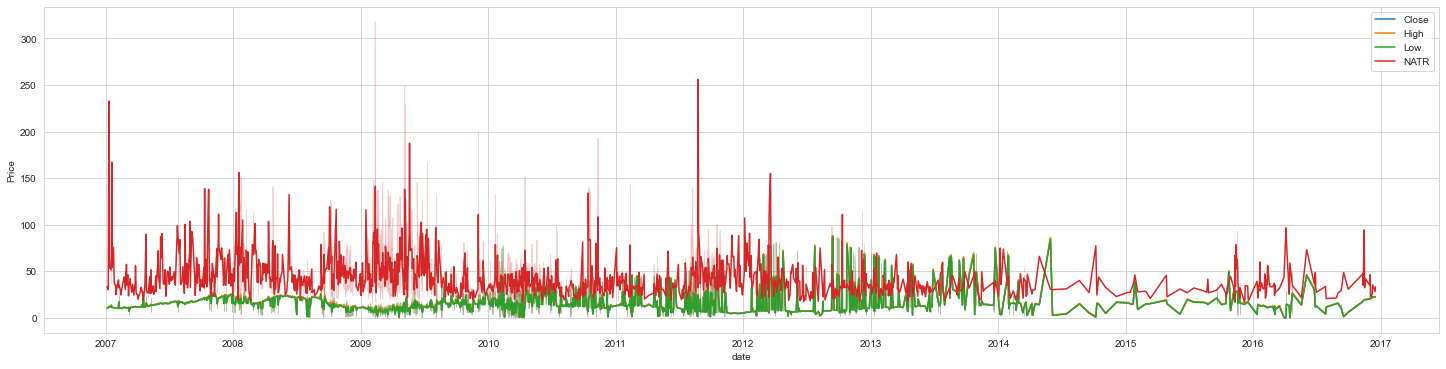

In [36]:
real = talib.NATR(mostTradedstocks['high'], mostTradedstocks['low'], mostTradedstocks['close'], timeperiod=14)

plt.figure(figsize=(25,6))
sns.lineplot(x = 'date', y = 'close', data=mostTradedstocks, label='Close')
sns.lineplot(x = 'date', y = 'high', data=mostTradedstocks, label='High')
sns.lineplot(x = 'date', y = 'low', data=mostTradedstocks, label='Low')
ax = sns.lineplot(x = 'date', y = real , data=mostTradedstocks, label='NATR')
ax.set(ylabel='Price')

## Rolling Factor Betas

## Persist results

In [37]:

with pd.HDFStore('feature_engineering_results.h5', mode = 'w') as store:
    store.put('df', mostTradedstocks, data_columns = mostTradedstocks.columns, format = 'table')